In [1]:
# this clones the PGM repository in the ./PGM folder if it does not exists
# please modify this line as needed if you want to have the PMG repository elsewhere
import os, sys
pgm_path = './PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append('./PGM/source/')
sys.path.append('./PGM/utilities/')
sys.path.append('./DNA_utils/')

In [2]:
# imports
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm, RBM_utils, utilities
import DNA_utils, DNA_sequence_logo, DNA_plots_utils

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn import metrics
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

./PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
./PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


In [3]:
# load RBMs
path = './trained_RBMs/'
file_name = 'RBM_SU8.data'
RBM_SU = RBM_utils.loadRBM(path + file_name)
RBM_SU.AIS(n_betas=100000,verbose=0)

Mismatch dimensions (500, 70), [10, 70], reinitializating I
Mismatch dimensions (500, 20, 4), [10, 20, 4], reinitializating I


(96.86137, 0.006448975075781816)

In [4]:
# load round 8 data
path = './data/'
filename = 's100_8th.fasta'
all_data_8, counts_8 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
full_data_8 = np.repeat(all_data_8, counts_8, axis=0)

# split left and right data
seqs_8_l_2num, counts_8_l = np.unique(full_data_8[:, :20], return_counts=True, axis=0)
all_data_8_l = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_l_2num),
                             'counts' : counts_8_l})

seqs_8_r_2num, counts_8_r = np.unique(full_data_8[:, 20:], return_counts=True, axis=0)
all_data_8_r = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_r_2num),
                             'counts' : counts_8_r})

# put both rounds together
all_data_8_lr = pd.concat([all_data_8_l, all_data_8_r])
all_data_8_lr = all_data_8_lr.reset_index(drop=True)
all_data_8_lr = all_data_8_lr.groupby(by=["sequence"], as_index=False).sum()
all_data_8_lr = all_data_8_lr.sort_values(by='counts', ascending=False).reset_index(drop=True)
all_seq_8_lr = DNA_utils.seq2num(all_data_8_lr["sequence"].to_list())
counts_8_lr = all_data_8_lr['counts'].to_numpy()

In [5]:
# load experimental data
filename = './data/Aptamer_Exp_Results.csv'
exp_df = pd.read_csv(filename)
exp_rounds = []
for l in exp_df['label']:
    if 'd' in l:
        exp_rounds.append(1)
    elif ('r' in l) and (int(l[1:]) <= 23):
        exp_rounds.append(2)
    elif 'p' in l:
        exp_rounds.append(3)
    else:
        exp_rounds.append(4)
exp_df['experimental_round'] = exp_rounds

In [6]:
# add distance information (from full round 8)
expseqs = DNA_utils.seq2num(exp_df["sequence"].to_list())
dists_from_round8 = [min(np.array([np.count_nonzero(x) for x in s != all_seq_8_lr])) for s in expseqs]
exp_df['dist_round8'] = dists_from_round8

In [7]:
# prepare data for plotting - first round
pre_good_binders = exp_df[(exp_df['experimental_round']==1) & (exp_df['binder']=='B')]['sequence'].to_list()
# add ThA, ThB, ThC and ThD to these
pre_good_binders = pre_good_binders + ["AGGGATGATGTGTGGTAGGC","AGGGTAGGTGTGGATGATGC",
                                       "TAGGTTTTGGGTAGGGTGGT","GTAGGATGGGTAGGGTGGTC"]

pre_bad_binders = exp_df[(exp_df['experimental_round']==1) & (exp_df['binder']=='NB')]['sequence'].to_list()

pre_binders_2num = DNA_utils.seq2num(pre_good_binders)
pre_nonbinders_2num = DNA_utils.seq2num(pre_bad_binders)

In [8]:
# prepare data for plotting - second round
good_binders = exp_df[(exp_df['experimental_round']==2) & (exp_df['binder']=='B')]['sequence'].to_list()
bad_binders = exp_df[(exp_df['experimental_round']==2) & (exp_df['binder']=='NB')]['sequence'].to_list()

good_binders += exp_df[(exp_df['experimental_round']==4) & (exp_df['binder']=='B') & (exp_df['dist_round8']>0)]['sequence'].to_list()
bad_binders += exp_df[(exp_df['experimental_round']==4) & (exp_df['binder']=='NB') & (exp_df['dist_round8']>0)]['sequence'].to_list()

binders_2num = DNA_utils.seq2num(good_binders)
nonbinders_2num = DNA_utils.seq2num(bad_binders)

In [9]:
# loglik computations
scores_train = RBM_SU.likelihood(all_seq_8_lr)
scores_pos_pre = RBM_SU.likelihood(pre_binders_2num)
scores_neg_pre = RBM_SU.likelihood(pre_nonbinders_2num)

np.random.seed(0)
rand_data = np.random.randint(low=0, high=3, size=(100000, 20), dtype=np.int16)
scores_pos = RBM_SU.likelihood(binders_2num)
scores_neg = RBM_SU.likelihood(nonbinders_2num)
scores_rand = RBM_SU.likelihood(rand_data)

In [10]:
# find threshold
lims = [min(scores_neg_pre), max(scores_pos_pre)]
step = 0.001
curr_thresh = lims[0]
curr_errs = np.sum(scores_pos_pre < curr_thresh) + np.sum(scores_neg_pre > curr_thresh)
min_errs = curr_errs
best_threshs = [curr_thresh]
while curr_thresh < lims[1]:
    curr_thresh += step
    curr_errs = np.sum(scores_pos_pre < curr_thresh) + np.sum(scores_neg_pre > curr_thresh)
    if curr_errs < min_errs:
        best_threshs = [curr_thresh]
        min_errs = curr_errs
    elif curr_errs == min_errs:
        best_threshs.append(curr_thresh)
threshold = np.mean(best_threshs)
print("Threshold position:", threshold)

Threshold position: -20.777267211908416


In [11]:
# load distance data (sampling sequences and computing distances takes time, so I use here pre-computed data)
rand_dists = np.loadtxt("./precomputed_data/rand_dists_from8.txt")
dists_sc = np.loadtxt("./precomputed_data/genRBMSC_dists_from8.txt")
dists_su = np.loadtxt("./precomputed_data/genRBMSU_dists_from8.txt")

In [12]:
# load RBM-SU vs RBM-SC training/testU/testC data (training models takes time, so I use here pre-computed data)
logliks_train_SU = np.loadtxt("./precomputed_data/logliks_train_SU.txt")
logliks_test_SU = np.loadtxt("./precomputed_data/logliks_test_SU.txt")
logliks_train_SC = np.loadtxt("./precomputed_data/logliks_train_SC.txt")
logliks_testC_SC = np.loadtxt("./precomputed_data/logliks_test_SC.txt")
logliks_testU_SC = np.loadtxt("./precomputed_data/logliks_testU_SC.txt")

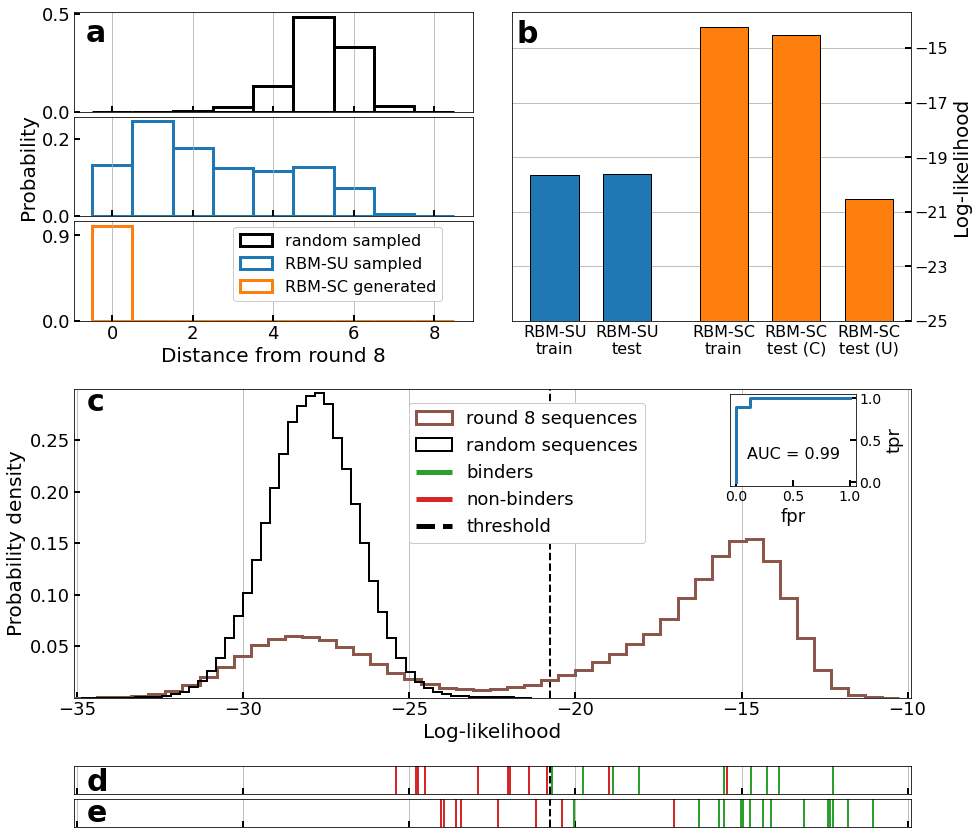

In [13]:
# make plot
fig = plt.figure(figsize=(15,15))
hr0 = [1, 1, 0.2]
gs = fig.add_gridspec(ncols=2, nrows=3, wspace=0.1, hspace=0.3, height_ratios=hr0)
####################################################################################################

gs01 = gs[0, 0].subgridspec(ncols=1, nrows=3, hspace=0.05)

bins = np.arange(-0.5, 9.5, 1)
ax001 = fig.add_subplot(gs01[0,0])
ax001.hist(rand_dists, density=True, histtype='bar', fill=False, bins=bins, lw=3, edgecolor="k",
         label="random sequences", zorder=10)
ax001.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax001.tick_params(axis='both', labelsize=18)
ax001.xaxis.grid()
ax001.set_xticklabels([])

ax002 = fig.add_subplot(gs01[1,0])
ax002.hist(dists_su, density=True, histtype='bar', fill=False, bins=bins, lw=3, edgecolor="C0",
         label="RBM-SU generated", zorder=1)
ax002.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax002.tick_params(axis='both', labelsize=18)
ax002.xaxis.grid()
ax002.set_xticklabels([])
ax002.set_ylabel("Probability", fontsize=20)

ax003 = fig.add_subplot(gs01[2,0])
### only for the legend
ax003.hist([], histtype='bar', fill=False,  lw=3, edgecolor="k", label="random sampled")
ax003.hist([], histtype='bar', fill=False,  lw=3, edgecolor="C0", label="RBM-SU sampled")
###
ax003.hist(dists_sc, density=True, histtype='bar', fill=False, bins=bins, lw=3, edgecolor="C1",
         label="RBM-SC generated", zorder=1)
ax003.legend(fontsize=16, loc=(0.4, 0.2), framealpha=1)

ax003.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax003.tick_params(axis='both', labelsize=18)
ax003.set_yticks([0.0, 0.9])
ax003.set_xticks([0, 2, 4, 6, 8])
ax003.xaxis.grid()
ax003.set_xlabel("Distance from round 8", fontsize=20)
ax001.text(0.03, 0.7, 'a', fontsize=30, color='k', weight='bold', transform=ax001.transAxes)


####################################################################################################
ax02 = fig.add_subplot(gs[0,1])

y0 = 25
xposs = [0, 1.2, 2.8, 4, 5.2]
ax02.bar(xposs[:2], [y0 + np.mean(logliks_train_SU), y0 + np.mean(logliks_test_SU)], 
          edgecolor="k", zorder=10)

ax02.bar(xposs[2:], [y0 + np.mean(logliks_train_SC), y0 + np.mean(logliks_testC_SC), y0 + np.mean(logliks_testU_SC)], 
          edgecolor="k", zorder=10)

ax02.yaxis.tick_right()
ax02.yaxis.set_label_position("right")

ax02.set_xticks(xposs)
ax02.set_xticklabels(["RBM-SU\ntrain", "RBM-SU\ntest",
                      "RBM-SC\ntrain", "RBM-SC\ntest (C)", "RBM-SC\ntest (U)"], rotation=0)
ax02.yaxis.grid(zorder=-10)
ax02.set_yticks(np.arange(0,11,2))
ax02.set_yticklabels(['\N{MINUS SIGN}' + str(-x) for x in np.arange(0,11,2)-y0])

ax02.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax02.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax02.tick_params(axis='both', labelsize=16)
ax02.set_ylabel("Log-likelihood", fontsize=20)

ax02.text(0.01, 0.9, 'b', fontsize=30, color='k', weight='bold', transform=ax02.transAxes)

####################################################################################################
t_ax = fig.add_subplot(gs[1,:])
t_ax.hist(scores_train, density=True, histtype='step', fill=False, bins=50, lw=3, color="C5",
         label="round 8 sequences", zorder=10)
t_ax.hist(scores_rand, density=True, histtype='step', fill=False, bins=50, lw=2, color="k",
         label="random sequences", zorder=13)
# threshold
t_ax.vlines(threshold, ymin=0, ymax=1, lw=2, ls='dashed', color="black")
    
# only for the legend
t_ax.vlines(0, ymin=0, ymax=1, lw=5, color="C2", label="binders")
t_ax.vlines(0, ymin=0, ymax=1, lw=5, color="C3", label="non-binders")
t_ax.vlines(0, ymin=0, ymax=1, lw=5, ls='dashed', color="black", label="threshold")
t_ax.legend(fontsize=18, loc=(0.4, 0.5), framealpha=1)

t_ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
t_ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
t_ax.tick_params(axis='both', labelsize=18)
t_ax.set_xlim((-35.1,-9.9))
t_ax.set_ylim((0,0.3))
t_ax.set_xlabel("Log-likelihood", fontsize=20)
t_ax.set_ylabel("Probability density", fontsize=20)
t_ax.set_yticks([0.05, 0.10, 0.15, 0.20, 0.25])

# inset
labels = np.hstack((np.zeros((len(scores_neg))), np.ones((len(scores_pos))))) 
scores = np.hstack((scores_neg, scores_pos))
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
axins = inset_axes(t_ax, width="100%", height="100%",
                   bbox_to_anchor=(.79, .7, .15, .3),
                   bbox_transform=t_ax.transAxes)
axins.plot(fpr, tpr, lw=3) 
axins.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
axins.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
axins.tick_params(axis='both', labelsize=14)
axins.set_xticks([0,0.5,1])
axins.set_yticks([0,0.5,1])
auc = metrics.auc(fpr, tpr)
axins.text(0.13, 0.3, "AUC = "+str(round(auc,2)), fontsize=16, color='k', transform=axins.transAxes)
axins.set_xlabel("fpr", fontsize=18)
axins.set_ylabel("tpr", fontsize=18)
axins.yaxis.tick_right()
axins.yaxis.set_label_position("right")
t_ax.text(0.015, 0.93, 'c', fontsize=30, color='k', weight='bold', transform=t_ax.transAxes)
t_ax.xaxis.grid()
#################################################################################################################
gs2 = gs[2, :].subgridspec(ncols=1, nrows=2, hspace=0.2)

ax2 = fig.add_subplot(gs2[0,:])
for sp in scores_pos_pre:
    ax2.vlines(sp, ymin=0, ymax=1, lw=2, color="C2")
for sn in scores_neg_pre:
    ax2.vlines(sn, ymin=0, ymax=1, lw=2, color="C3")
ax2.vlines(threshold, ymin=0, ymax=1, lw=2, ls='dashed', color="black")
ax2.set_yticks([])
ax2.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax2.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax2.set_xlim((-35.1,-9.9))
ax2.set_ylim((0,1))
ax2.set_xticklabels([])
#ax2.set_xlabel('Threshold calibration', fontsize=20)
ax2.text(0.015, 0.1, 'd', fontsize=30, color='k', weight='bold', transform=ax2.transAxes)
ax2.xaxis.grid()
#################################################################################################################
ax3 = fig.add_subplot(gs2[1,:])
for sp in scores_pos:
    ax3.vlines(sp, ymin=0, ymax=1, lw=2, color="C2")
for sn in scores_neg:
    ax3.vlines(sn, ymin=0, ymax=1, lw=2, color="C3")
ax3.vlines(threshold, ymin=0, ymax=1, lw=2, ls='dashed', color="black")
ax3.set_yticks([])
ax3.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax3.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax3.tick_params(axis='both', labelsize=18)
ax3.set_xticklabels([])
ax3.set_xlim((-35.1,-9.9))
ax3.set_ylim((0,1))
ax3.text(0.015, 0.2, 'e', fontsize=30, color='k', weight='bold', transform=ax3.transAxes)
ax3.xaxis.grid()
#################################################################################################################